In [1]:
# Comparing using some data vs all data when not much has been collected yet.
# Goal is to choose between many sampled models or one model with many agents.

In [1]:
import multiprocessing 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import copy

import model_based_agent as mba 
import ensemble_mod_env as eme
import utils as ut
import tab_agents as tab

from datetime import datetime 

# 0. Find a decent set of smoothing parameters

In [5]:
dh = mba.DataHandler()
dh.load_df('ensemble_testing.pkl')

In [16]:
mod = eme.ModelSet(1,frac=1)
lambdas = [.1,.25,.5,.75,1]
iters = [5,10,20,30,50]
mods = {'body_on':[[] for _ in range(5)],
        'body_off':[[] for _ in range(5)],
        'head_on':[[] for _ in range(5)],
        'head_off':[[] for _ in range(5)],
        'reward_on':[[] for _ in range(5)],
        'reward_off':[[] for _ in range(5)],}
for i_l,l in enumerate(lambdas):  
    for it in iters:
        print(l,it)
        mod.make_models(dh,{'lambda':l,'iters':it})
        for key,item in mod.models[0].items():
            mods[key][i_l].append(item)

0.1 5
On model 0
0.1 10
On model 0
0.1 20
On model 0
0.1 30
On model 0
0.1 50
On model 0
0.25 5
On model 0
0.25 10
On model 0
0.25 20
On model 0
0.25 30
On model 0
0.25 50
On model 0
0.5 5
On model 0
0.5 10
On model 0
0.5 20
On model 0
0.5 30
On model 0
0.5 50
On model 0
0.75 5
On model 0
0.75 10
On model 0
0.75 20
On model 0
0.75 30
On model 0
0.75 50
On model 0
1 5
On model 0
1 10
On model 0
1 20
On model 0
1 30
On model 0
1 50
On model 0


In [17]:
def plot_key(mods,key,lambdas,iters):
    fig,ax = plt.subplots(len(lambdas),len(iters))
    fig.set_size_inches((12,12))
    for i_l,l in enumerate(lambdas):
        for i_it, it in enumerate(iters):
            img = ax[i_l,i_it].imshow(mods[key][i_l][i_it][:,:,0])
            fig.colorbar(img,ax=ax[i_l,i_it])
            ax[i_l,i_it].set_title(f'Lambda {l},Iters {it}')
            ax[i_l,i_it].axis('off')

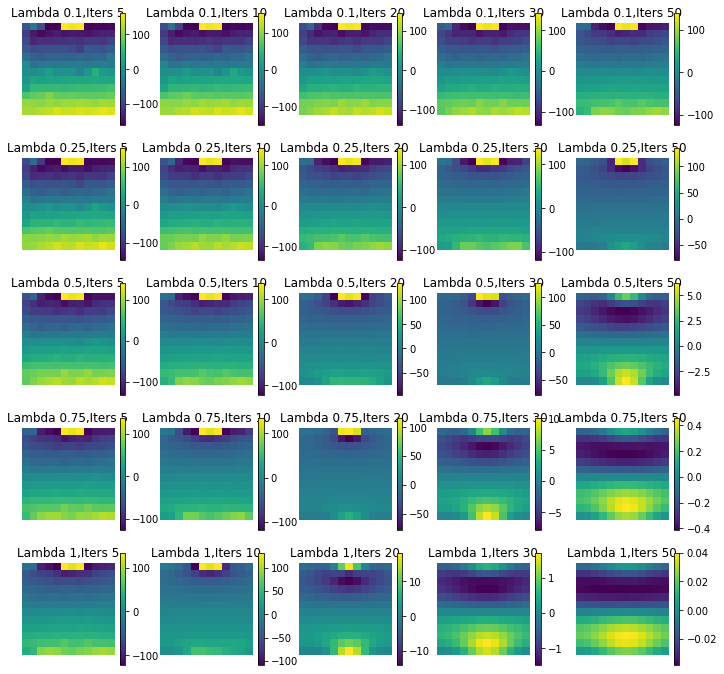

In [22]:
plot_key(mods,'body_on',lambdas,iters)

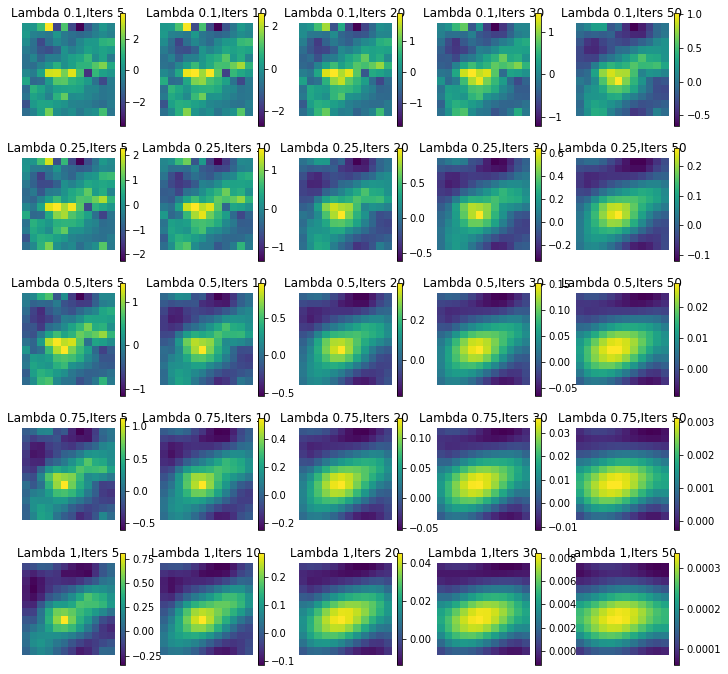

In [24]:
plot_key(mods,'reward_off',lambdas,iters)

# 1. Look at models w increasing amounts of data

In [36]:
def mods_w_diff_samples(n_models,handler,samples):
    # Returns a list of models 
    mods = []
    mods=eme.ModelSet(n_models,samples=samples)
    mods.make_models(handler,sm_pars={'lambda':.25,'iters':10})
    return mods.models

def plot_mods(models):
    fig,ax = plt.subplots(len(mods),6)
    fig.set_size_inches((15,2*len(mods)))
    for m,mod in enumerate(models):
        for i,(key,item) in enumerate(mod.items()):
            if i<4:
                img = ax[m,i].imshow(item[:,:,0],vmin=-180,vmax=180)
            else:
                img = ax[m,i].imshow(item[:,:,0],vmin=-1,vmax=1)
            fig.colorbar(img,ax=ax[m,i])
            ax[m,i].axis('off')
            if m==0:
                ax[m,i].set_title(f'{len(mods)} models: {key}')

On model 0
On model 1
On model 2


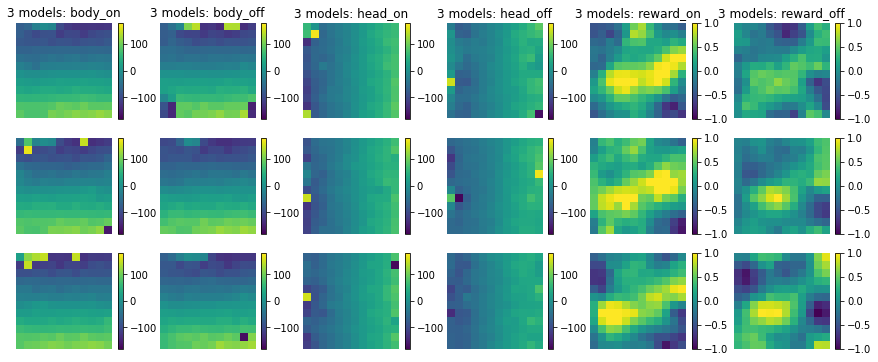

In [37]:
mods = mods_w_diff_samples(3,dh,5000)
plot_mods(mods)

On model 0
On model 1
On model 2


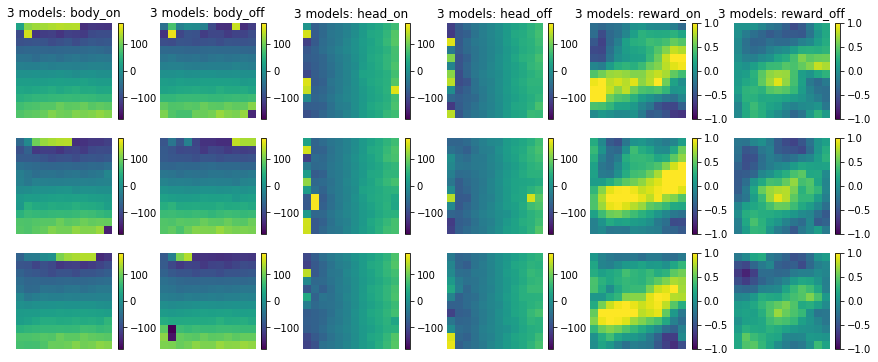

In [38]:
mods = mods_w_diff_samples(3,dh,10000)
plot_mods(mods)

On model 0
On model 1
On model 2


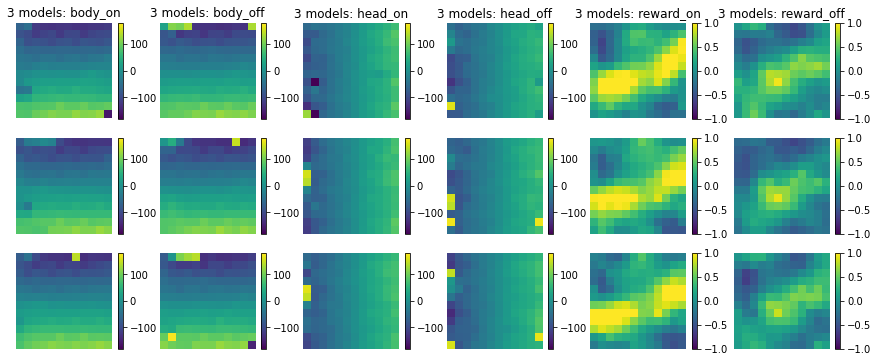

In [39]:
mods = mods_w_diff_samples(3,dh,15000)
plot_mods(mods)

On model 0
On model 1
On model 2


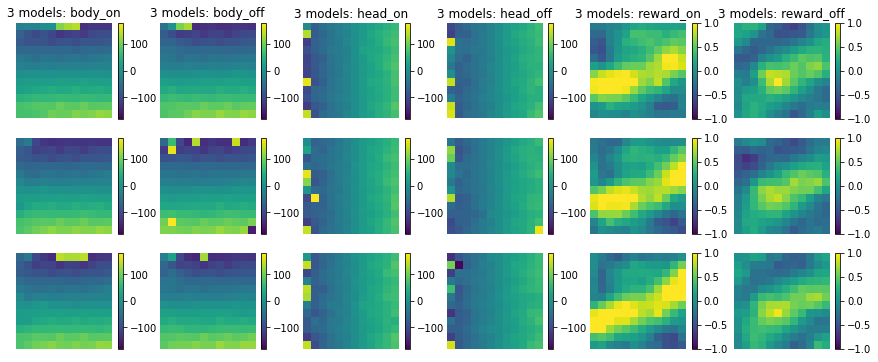

In [40]:
mods = mods_w_diff_samples(3,dh,20000)
plot_mods(mods)

On model 0
On model 1
On model 2


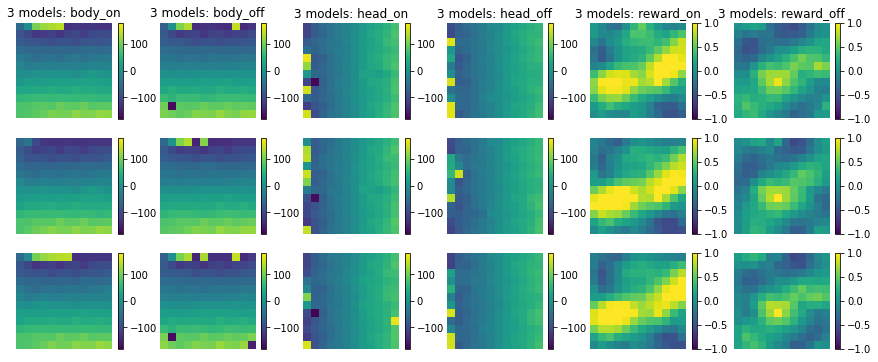

In [41]:
mods = mods_w_diff_samples(3,dh,30000)
plot_mods(mods)

# 2. Find out which learns faster: many sampled models or one main model.
Either way, uses lots of agents.

In [2]:
def multiproc_sampled_models(
    num_learners = 10,
    collection_eps = 5,
    gamma=.25,
    epsilon=.01,
    alpha=.05,
    df_bound=-1,
    learn_limit=2000,
    frac=.5,
    init_df = 'ensemble_testing.pkl',
):
    '''
    Runs parallel learners and joins them afterward
    '''
    qtabs = []
    worm_agent = tab.Q_Alpha_Agent(gamma=gamma, epsilon=epsilon, alpha=alpha) # Agent doesn't learn
    # Start model environments and learners 
    dh = mba.DataHandler()
    dh.load_df(init_df)
    dh.df = dh.df[:df_bound]
    
    for loop in range(collection_eps):        
        # Make new learner list based on newest data
        learners = mba.make_learner_list(num_learners, worm_pars={'num_models':1, 'frac':frac},
                                gamma=gamma, epsilon=epsilon, alpha=alpha, q_checkpoint=worm_agent.Qtab)        
        
        # Start multiprocessing
        manager = multiprocessing.Manager()
        poison_queue = manager.Queue()
        pool = multiprocessing.Pool()
        
        # Run main functions: train agents and collect more data
        lea_outs = []
        print(loop)
        for lea in learners:
            lea_outs.append(pool.apply_async(lea.learn, [dh],{'learn_limit':learn_limit}))
        # Wait for them to finish
        pool.close()
        pool.join()
        for lea_out in lea_outs:
            if lea_out.successful() is False:
                raise Exception('One learner failed')
        
        # Combining learners from run
        worm_agent.Qtab = mba.combine_learners(lea_outs)
        qtabs.append(worm_agent.Qtab.reshape((12,12,2)))
    return qtabs

def plot_qtabs(qset,title,vmin=None,vmax=None):
    # Takes a set of qtables and plots them 
    fig,ax = plt.subplots(2,len(qset))
    fig.suptitle(title)
    fig.set_size_inches((3*len(qset),5))
    for i,qs in enumerate(qset):
        for j in range(2):
            img = ax[j,i].imshow(qs[:,:,j],vmin=vmin,vmax=vmax)
            fig.colorbar(img,ax=ax[j,i])
            ax[j,i].axis('off')

## 2.a. Many sampled models

In [3]:
if __name__=='__main__':
    all_qs = []
    df_bounds = [5000,10000,20000,-1]
    for df_b in df_bounds:
        all_qs.append(multiproc_sampled_models(df_bound=df_b))

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


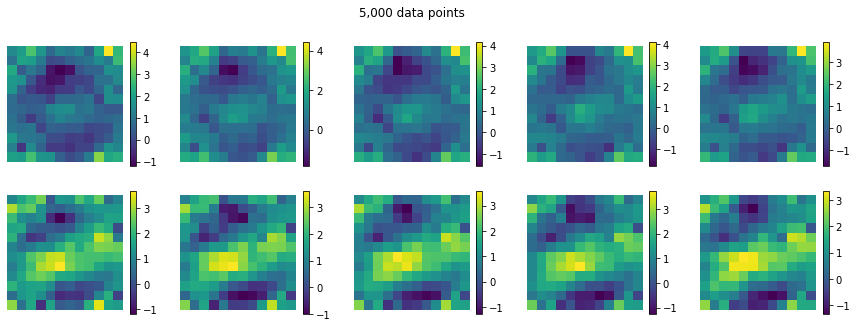

In [4]:
plot_qtabs(all_qs[0],'5,000 data points')

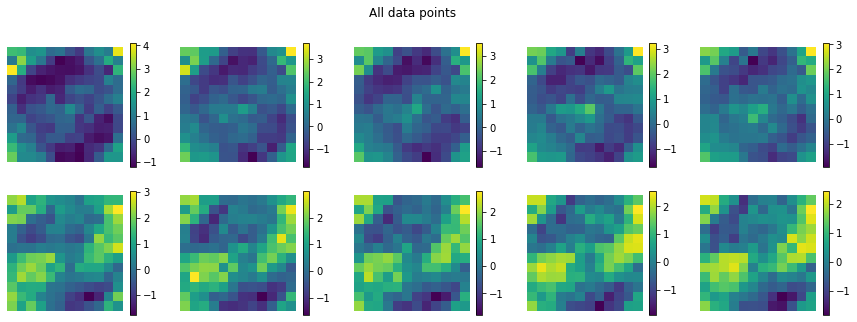

In [5]:
plot_qtabs(all_qs[-1],'All data points')

## 2.b. One main model

In [6]:
if __name__=='__main__':
    all_qs = []
    df_bounds = [5000,10000,20000,-1]
    for df_b in df_bounds:
        all_qs.append(multiproc_sampled_models(df_bound=df_b,frac=1))

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


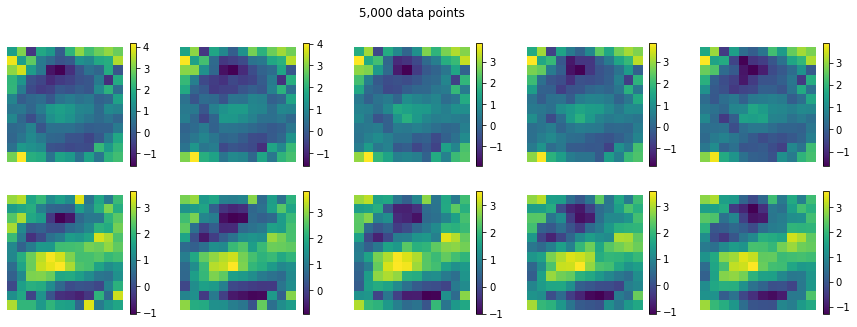

In [7]:
plot_qtabs(all_qs[0],'5,000 data points')

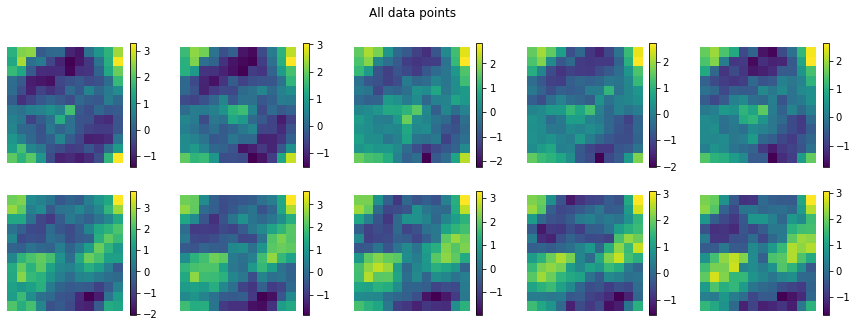

In [8]:
plot_qtabs(all_qs[-1],'All data points')